

In general, An Ensemble Voting Model consist of Random Forest, Neural Network and KNN are used for the classification task of predicting the Type of Crime.

In [1]:
# Visualization Libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

# ML Libraries
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Evaluation Metrics
from yellowbrick.classifier import ClassificationReport
from sklearn import metrics

In [2]:
df = pd.concat([pd.read_csv('../input/Chicago_Crimes_2001_to_2004.csv', error_bad_lines=False), pd.read_csv('../input/Chicago_Crimes_2005_to_2007.csv', error_bad_lines=False)], ignore_index=True)
df = pd.concat([df, pd.read_csv('../input/Chicago_Crimes_2008_to_2011.csv', error_bad_lines=False)], ignore_index=True)
df = pd.concat([df, pd.read_csv('../input/Chicago_Crimes_2012_to_2017.csv', error_bad_lines=False)], ignore_index=True)
df.head()

b'Skipping line 1513591: expected 23 fields, saw 24\n'
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (17,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,879,4786321,HM399414,01/01/2004 12:01:00 AM,082XX S COLES AVE,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,424,4.0,7.0,46.0,06,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
1,2544,4676906,HM278933,03/01/2003 12:00:00 AM,004XX W 42ND PL,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,True,935,9.0,11.0,61.0,26,1173974.0,1.87676e+06,2003.0,04/15/2016 08:55:02 AM,41.8172,-87.637328,"(41.817229156, -87.637328162)"
2,2919,4789749,HM402220,06/20/2004 11:00:00 AM,025XX N KIMBALL AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,False,1413,14.0,35.0,22.0,20,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
3,2927,4789765,HM402058,12/30/2004 08:00:00 PM,045XX W MONTANA ST,0840,THEFT,FINANCIAL ID THEFT: OVER $300,OTHER,False,False,2521,25.0,31.0,20.0,06,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
4,3302,4677901,HM275615,05/01/2003 01:00:00 AM,111XX S NORMAL AVE,0841,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,False,False,2233,22.0,34.0,49.0,06,1174948.0,1.83105e+06,2003.0,04/15/2016 08:55:02 AM,41.6918,-87.635116,"(41.691784636, -87.635115968)"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7941282 entries, 0 to 7941281
Data columns (total 23 columns):
Unnamed: 0              int64
ID                      int64
Case Number             object
Date                    object
Block                   object
IUCR                    object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                object
X Coordinate            float64
Y Coordinate            object
Year                    float64
Updated On              object
Latitude                object
Longitude               float64
Location                object
dtypes: bool(2), float64(6), int64(3), object(12)
memory usage: 1.3+ GB


In [ ]:
# Preprocessing
# Remove NaN Value (As Dataset is huge, the NaN row could be neglectable)  
df = df.dropna()

In [5]:
# As the dataset is too huge is size, we would just subsampled a dataset for modelling as proof of concept
df = df.sample(n=100000)

In [6]:
# Remove irrelevant/not meaningfull attributes
df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop(['ID'], axis=1)
df = df.drop(['Case Number'], axis=1) 

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 2369204 to 981279
Data columns (total 20 columns):
Date                    100000 non-null object
Block                   100000 non-null object
IUCR                    100000 non-null object
Primary Type            100000 non-null object
Description             100000 non-null object
Location Description    100000 non-null object
Arrest                  100000 non-null bool
Domestic                100000 non-null bool
Beat                    100000 non-null int64
District                100000 non-null float64
Ward                    100000 non-null float64
Community Area          100000 non-null float64
FBI Code                100000 non-null object
X Coordinate            100000 non-null float64
Y Coordinate            100000 non-null object
Year                    100000 non-null float64
Updated On              100000 non-null object
Latitude                100000 non-null object
Longitude               100000 non-nu

In [7]:
# Splitting the Date to Day, Month, Year, Hour, Minute, Second
df['date2'] = pd.to_datetime(df['Date'])
df['Year'] = df['date2'].dt.year
df['Month'] = df['date2'].dt.month
df['Day'] = df['date2'].dt.day
df['Hour'] = df['date2'].dt.hour
df['Minute'] = df['date2'].dt.minute
df['Second'] = df['date2'].dt.second 
df = df.drop(['Date'], axis=1) 
df = df.drop(['date2'], axis=1) 
df = df.drop(['Updated On'], axis=1)
df.head()

,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude,Location,Month,Day,Hour,Minute,Second
2369204,004XX E MC FETRIDGE DR,1110,DECEPTIVE PRACTICE,BOGUS CHECK,LAKEFRONT/WATERFRONT/RIVERBANK,False,False,133,1.0,2.0,33.0,11,1179330.0,1.89421e+06,2007,41.865,-87.617147,"(41.865000681, -87.617147205)",1,21,16,0,0
4010772,041XX W IRVING PARK RD,0820,THEFT,$500 AND UNDER,SIDEWALK,False,False,1732,17.0,39.0,16.0,06,1148252.0,1.92627e+06,2008,41.9536,-87.730408,"(41.953620328, -87.730408248)",7,2,20,15,0
7581223,010XX N CLARK ST,1150,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,ATHLETIC CLUB,False,False,1824,18.0,42.0,8.0,11,1175350.0,1.90732e+06,2015,41.9011,-87.631364,"(41.901073698, -87.63136393)",8,15,15,42,0
2542868,006XX E GRAND AVE,0460,BATTERY,SIMPLE,OTHER,False,False,1834,18.0,42.0,8.0,08B,1180796.0,1.90406e+06,2006,41.892,-87.611462,"(41.891990384, -87.611461502)",6,14,7,0,0
2932411,002XX W 90TH PL,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,634,6.0,21.0,49.0,14,1176339.0,1.84482e+06,2007,41.7295,-87.629611,"(41.729545876, -87.629611288)",4,30,1,10,0


In [8]:
# Convert Categorical Attributes to Numerical
df['Block'] = pd.factorize(df["Block"])[0]
df['IUCR'] = pd.factorize(df["IUCR"])[0]
df['Description'] = pd.factorize(df["Description"])[0]
df['Location Description'] = pd.factorize(df["Location Description"])[0]
df['FBI Code'] = pd.factorize(df["FBI Code"])[0]
df['Location'] = pd.factorize(df["Location"])[0] 

In [9]:
Target = 'Primary Type'
print('Target: ', Target)

Target:  Primary Type


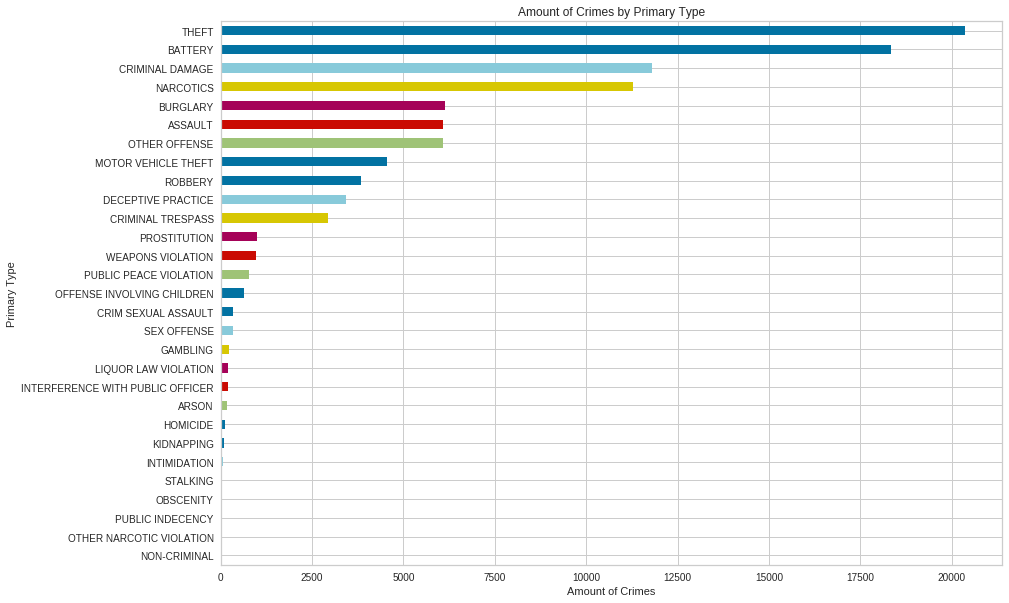

In [10]:
# Plot Bar Chart visualize Primary Types
plt.figure(figsize=(14,10))
plt.title('Amount of Crimes by Primary Type')
plt.ylabel('Crime Type')
plt.xlabel('Amount of Crimes')

df.groupby([df['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')

plt.show()

In [11]:
# At previous plot, we could see that the classes is quite imbalance
# Therefore, we are going to group several less occured Crime Type into 'Others' to reduce the Target Class amount

# First, we sum up the amount of Crime Type happened and select the last 13 classes
all_classes = df.groupby(['Primary Type'])['Block'].size().reset_index()
all_classes['Amt'] = all_classes['Block']
all_classes = all_classes.drop(['Block'], axis=1)
all_classes = all_classes.sort_values(['Amt'], ascending=[False])

unwanted_classes = all_classes.tail(13)
unwanted_classes

,Primary Type,Amt
25,SEX OFFENSE,330
8,GAMBLING,215
13,LIQUOR LAW VIOLATION,202
10,INTERFERENCE WITH PUBLIC OFFICER,194
0,ARSON,171
9,HOMICIDE,118
12,KIDNAPPING,87
11,INTIMIDATION,56
26,STALKING,45
17,OBSCENITY,17


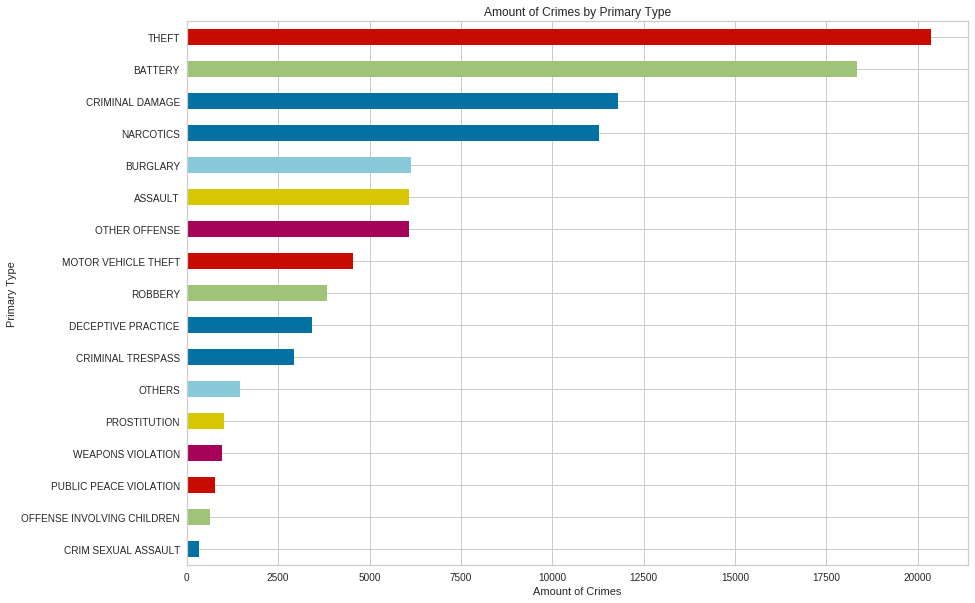

In [12]:
# After that, we replaced it with label 'OTHERS'
df.loc[df['Primary Type'].isin(unwanted_classes['Primary Type']), 'Primary Type'] = 'OTHERS'

# Plot Bar Chart visualize Primary Types
plt.figure(figsize=(14,10))
plt.title('Amount of Crimes by Primary Type')
plt.ylabel('Crime Type')
plt.xlabel('Amount of Crimes')

df.groupby([df['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')

plt.show()

In [13]:
# Now we are left with 14 Class as our predictive class
Classes = df['Primary Type'].unique()
Classes

array(['DECEPTIVE PRACTICE', 'THEFT', 'BATTERY', 'CRIMINAL DAMAGE',
       'NARCOTICS', 'OTHERS', 'ROBBERY', 'OTHER OFFENSE', 'ASSAULT',
       'MOTOR VEHICLE THEFT', 'BURGLARY', 'PUBLIC PEACE VIOLATION',
       'CRIMINAL TRESPASS', 'OFFENSE INVOLVING CHILDREN',
       'WEAPONS VIOLATION', 'CRIM SEXUAL ASSAULT', 'PROSTITUTION'],
      dtype=object)

In [14]:
#Encode target labels into categorical variables:
df['Primary Type'] = pd.factorize(df["Primary Type"])[0] 
df['Primary Type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

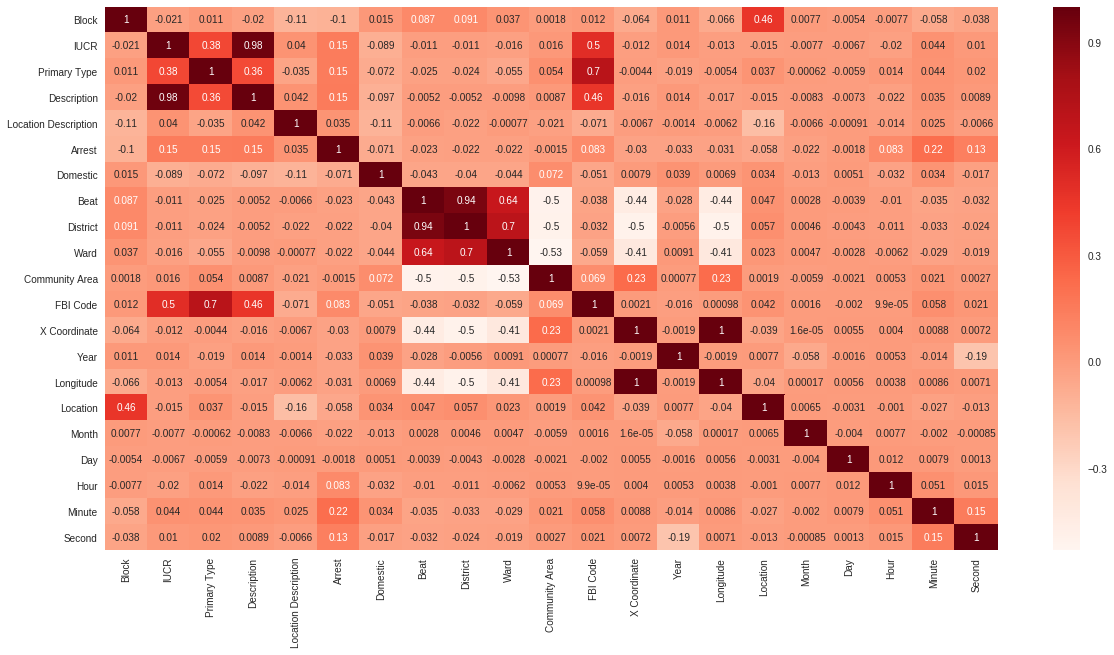

In [15]:
# Feature Selection using Filter Method 
# Split Dataframe to target class and features
X_fs = df.drop(['Primary Type'], axis=1)
Y_fs = df['Primary Type']

#Using Pearson Correlation
plt.figure(figsize=(20,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

**Further Elaboration of Correlation**

The correlation coefficient has values between -1 to 1
* A value closer to 0 implies weaker correlation (exact 0 implying no correlation)
* A value closer to 1 implies stronger positive correlation
* A value closer to -1 implies stronger negative correlation

In [16]:
#Correlation with output variable
cor_target = abs(cor['Primary Type'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2]
relevant_features

IUCR            0.378033
Primary Type    1.000000
Description     0.363889
FBI Code        0.703923
Name: Primary Type, dtype: float64

In [17]:
# At Current Point, the attributes is select manually based on Feature Selection Part. 
Features = ["IUCR", "Description", "FBI Code"]
print('Full Features: ', Features)

Full Features:  ['IUCR', 'Description', 'FBI Code']


In [18]:
#Split dataset to Training Set & Test Set
x, y = train_test_split(df, 
                        test_size = 0.2, 
                        train_size = 0.8, 
                        random_state= 3)

x1 = x[Features]    #Features to train
x2 = x[Target]      #Target Class to train
y1 = y[Features]    #Features to test
y2 = y[Target]      #Target Class to test

print('Feature Set Used    : ', Features)
print('Target Class        : ', Target)
print('Training Set Size   : ', x.shape)
print('Test Set Size       : ', y.shape)

Feature Set Used    :  ['IUCR', 'Description', 'FBI Code']
Target Class        :  Primary Type
Training Set Size   :  (80000, 23)
Test Set Size       :  (20000, 23)


**Machine Learning Modelling**

In [19]:
# Random Forest
# Create Model with configuration
rf_model = RandomForestClassifier(n_estimators=70, # Number of trees
                                  min_samples_split = 30,
                                  bootstrap = True, 
                                  max_depth = 50, 
                                  min_samples_leaf = 25)

# Model Training
rf_model.fit(X=x1,
             y=x2)

# Prediction
result = rf_model.predict(y[Features])

In [20]:
# Model Evaluation
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("========== Random Forest Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

========== Random Forest Results ==========
Accuracy    :  0.9948
Recall      :  0.9948
Precision   :  0.9946644456606959
F1 Score    :  0.9948
Confusion Matrix: 
[[ 689    0    0    0    0    4    0    0    0    0    0    0    0    0
     0    0    0]
 [   0 4138    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0 3675    0    0    2    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    0 2394    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0 2302    0    0    1    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    1  249    9   17   11    1    0   12    0    0
     0    0    0]
 [   0    0    0    0    0    0  735    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    0    1 1180    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    0    0    0 1164    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0 

================= Classification Report =================

                            precision    recall  f1-score   support

        DECEPTIVE PRACTICE       1.00      0.99      1.00       693
                     THEFT       1.00      1.00      1.00      4138
                   BATTERY       1.00      1.00      1.00      3677
           CRIMINAL DAMAGE       1.00      1.00      1.00      2394
                 NARCOTICS       1.00      1.00      1.00      2303
                    OTHERS       0.91      0.83      0.87       300
                   ROBBERY       0.99      1.00      0.99       735
             OTHER OFFENSE       0.98      1.00      0.99      1181
                   ASSAULT       0.99      1.00      0.99      1164
       MOTOR VEHICLE THEFT       1.00      1.00      1.00       902
                  BURGLARY       1.00      1.00      1.00      1172
    PUBLIC PEACE VIOLATION       0.91      0.83      0.87       138
         CRIMINAL TRESPASS       1.00      1.00      1.0

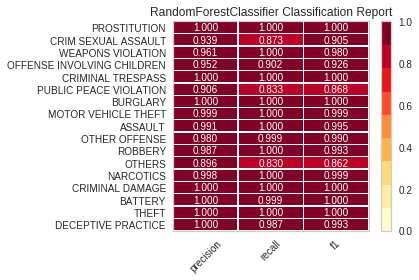

In [21]:
# Classification Report
# Instantiate the classification model and visualizer
target_names = Classes
visualizer = ClassificationReport(rf_model, classes=target_names)
visualizer.fit(X=x1, y=x2)     # Fit the training data to the visualizer
visualizer.score(y1, y2)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y2, result, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

In [22]:
# Neural Network
# Create Model with configuration 
nn_model = MLPClassifier(solver='adam', 
                         alpha=1e-5,
                         hidden_layer_sizes=(40,), 
                         random_state=1,
                         max_iter=1000                         
                        )

# Model Training
nn_model.fit(X=x1,
             y=x2)

# Prediction
result = nn_model.predict(y[Features]) 

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [23]:
# Model Evaluation
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("========== Neural Network Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

========== Neural Network Results ==========
Accuracy    :  0.93735
Recall      :  0.93735
Precision   :  0.9383425912666306
F1 Score    :  0.93735
Confusion Matrix: 
[[ 580    0   21    0    0    0   43    0    0    0   40    0    0    0
     0    0    9]
 [   0 4138    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0 3668    0    0    9    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    0 2394    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0 2290    0    0   12    0    0    0    0    0    1
     0    0    0]
 [   0    0   76    0    1  105    7   18   11    0   22    0    0   40
     0    0   20]
 [   0    0    0    0    0    0  729    0    0    0    0    0    0    6
     0    0    0]
 [   0    0    0    0    0    9    0  861    0    0    0    0  297   14
     0    0    0]
 [   0    0    0    0    0   10   51    0 1098    0    0    0    0    0
     0    0    5]
 [   0    0    0    0  

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


================= Classification Report =================

                            precision    recall  f1-score   support

        DECEPTIVE PRACTICE       1.00      0.84      0.91       693
                     THEFT       1.00      1.00      1.00      4138
                   BATTERY       0.96      1.00      0.98      3677
           CRIMINAL DAMAGE       1.00      1.00      1.00      2394
                 NARCOTICS       1.00      0.99      1.00      2303
                    OTHERS       0.51      0.35      0.41       300
                   ROBBERY       0.80      0.99      0.89       735
             OTHER OFFENSE       0.83      0.73      0.78      1181
                   ASSAULT       0.94      0.94      0.94      1164
       MOTOR VEHICLE THEFT       1.00      0.87      0.93       902
                  BURGLARY       0.90      0.94      0.92      1172
    PUBLIC PEACE VIOLATION       1.00      0.61      0.76       138
         CRIMINAL TRESPASS       0.63      0.87      0.7

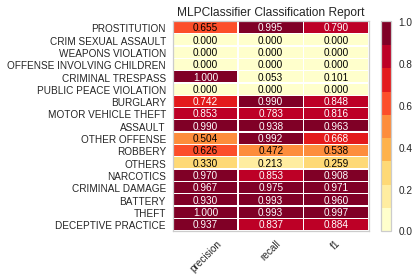

In [24]:
# Classification Report
# Instantiate the classification model and visualizer
target_names = Classes
visualizer = ClassificationReport(nn_model, classes=target_names)
visualizer.fit(X=x1, y=x2)     # Fit the training data to the visualizer
visualizer.score(y1, y2)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y2, result, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

In [25]:
# K-Nearest Neighbors
# Create Model with configuration 
knn_model = KNeighborsClassifier(n_neighbors=3)

# Model Training
knn_model.fit(X=x1,
             y=x2)

# Prediction
result = knn_model.predict(y[Features]) 

========== K-Nearest Neighbors Results ==========
Accuracy    :  0.9969
Recall      :  0.9969
Precision   :  0.9970585067721506
F1 Score    :  0.9969


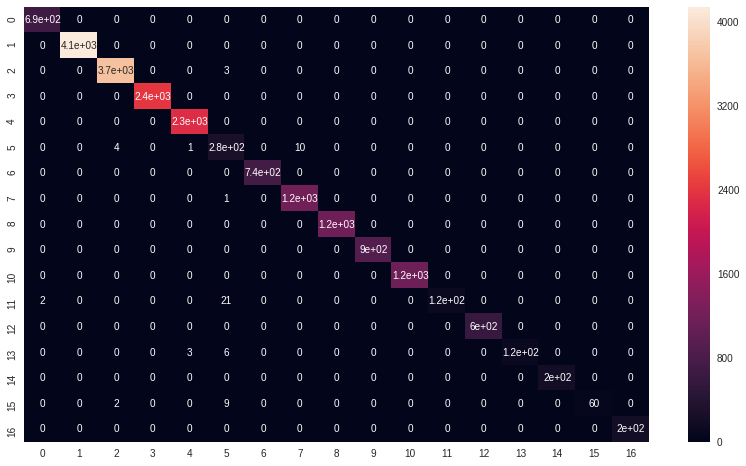

In [31]:
import seaborn as sns
# Model Evaluation
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("========== K-Nearest Neighbors Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
plt.figure(figsize=(14,8))
sns.heatmap(confusion_m, annot=True)

In [27]:
# Classification Report
# Instantiate the classification model and visualizer
target_names = Classes
visualizer = ClassificationReport(knn_model, classes=target_names)
visualizer.fit(X=x1, y=x2)     # Fit the training data to the visualizer
visualizer.score(y1, y2)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y2, result, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-bdc277a4acca>", line 5, in <module>
    visualizer.fit(X=x1, y=x2)     # Fit the training data to the visualizer
  File "/opt/conda/lib/python3.6/site-packages/yellowbrick/classifier/base.py", line 104, in fit
    self.estimator.fit(X, y)
  File "/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py", line 916, in fit
    return self._fit(X)
  File "/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py", line 258, in _fit
    **self.effective_metric_params_)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1863, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'Keyboard

KeyboardInterrupt: 

In [32]:
# Ensemble Voting Model
# Combine 3 Models to create an Ensemble Model

# Create Model with configuration
eclf1 = VotingClassifier(estimators=[('knn', knn_model), ('rf', rf_model), ('nn', nn_model)], 
                         weights=[1,1,1],
                         flatten_transform=True)
eclf1 = eclf1.fit(X=x1, y=x2)   

# Prediction
result = eclf1.predict(y[Features])

In [36]:
# Model Evaluation
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("============= Ensemble Voting Results =============")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

============= Ensemble Voting Results =============
Accuracy    :  0.9967
Recall      :  0.9967
Precision   :  0.9967194513739607
F1 Score    :  0.9967
Confusion Matrix: 
[[ 693    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0 4138    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0 3677    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    0 2394    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0 2302    0    0    1    0    0    0    0    0    0
     0    0    0]
 [   0    0    4    0    1  273    5   17    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    0  735    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    1    0 1180    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    0    0    0 1164    0    0    0    0    0
     0    0    0]
 [   0    0    0   

In [ ]:
# Classification Report
# Instantiate the classification model and visualizer
target_names = Classes
visualizer = ClassificationReport(eclf1, classes=target_names)
visualizer.fit(X=x1, y=x2)     # Fit the training data to the visualizer
visualizer.score(y1, y2)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y2, result, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data